<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF-393 Aprendizaje Automático II-2020 </h1>
    <h3> Taller 3</h3>
</center>

Nombres: Nicolás Rosas Gómez  & Camilo Núñez Fernández

Roles: 201573608-1 & 201573573-5

Correos:
nicolas.rosasg@sansano.usm.cl & camilo.nunezf@sansano.usm.cl
<hr style="height:2px;border:none"/>

**Temas**  

* Redes neuronales
* Máquinas de ensamblado
* Aprendizaje no-supervisado 

<hr style="height:2px;border:none"/>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

try:
    from fbprophet import Prophet
except ImportError:
    os.system('pip install pystan')
    os.system('pip install fbprophet')
    from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Importing plotly failed. Interactive plots will not work.


# Pregunta de Investigación

La tarea en esta ocasión se compone de una sola sección en la cual se les plantea un problema general o hipótesis a los autores y su trabajo consistirá en diseñar, implementar y medir una metodología de investigación en torno a la problemática mencionada en la pregunta, desde la adquisición de los datos y preprocesamiento hasta las conclusiones que permitan definir si es posible o no realizar la predicción y con qué grado de certeza/eficacia se puede hacer.

## Pregunta seleccionada: Detección temprana de lugares donde se están observando los efectos del cambio climático.
**Descripción**
> Son múltiples las visualizaciones de los efectos que ha tenido el cambio climático en el mediano plazo, sin embargo, muchos de estos efectos podrían haberse evitado con una temprana acción. De acuerdo a tweets y datos climáticos ¿es posible detectar de forma temprana los efectos del cambio climático de manera de tomar acciones preventivas?, ¿podemos aplicarlo a Chile?.

## Motivación

La detección de efectos del cambio climático se compone de muchas variables que pueden influir, como la temperatura terrestre de las zonas, la evapotranspiración en generación de zonas desérticas, o la baja en los índices de humedad, entre muchas más variables.

El presente trabajo tiene por objetivo desarrollar dos tipos de modelos capaces de predecir la temperatura superficial de las ciudades de Coquimbo, Valdivia, Antofagasta, Valparaíso, Concepción y Santiago.

## Dataset

El dataset selccionado correspoden al __Climate Change: Earth Surface Temperature Data__, el cual contiene los cambios de temperatura que han existido en el mundo desde el 1 de noviembre del 1743 hasta el 1 de diciembre de 2015. El dataset cuenta con múltiples archivos, de los cual se seleccionara el archivo `GlobalLandTemperaturesByCity`. Para este documento se trabajará en específico con los datos de Chile, en específico de las ciudades de Coquimbo, Valdivia, Antofagasta, Valparaíso, Concepción y Santiago

In [2]:
#cities = pd.read_csv('GlobalLandTemperaturesByCity.csv')
cities = pd.read_csv('GlobalLandTemperaturesByCity_CHILE.csv')
cities = cities.loc[cities['Country'] == 'Chile'].dropna()

In [4]:
cities.head()

dt  AverageTemperature  AverageTemperatureUncertainty  \
338909  1855-05-01              15.818                          1.219   
338910  1855-06-01              13.689                          2.200   
338911  1855-07-01              13.454                          1.412   
338912  1855-08-01              13.503                          1.197   
338913  1855-09-01              12.900                          1.096   

               City Country Latitude Longitude  
338909  Antofagasta   Chile   23.31S    70.78W  
338910  Antofagasta   Chile   23.31S    70.78W  
338911  Antofagasta   Chile   23.31S    70.78W  
338912  Antofagasta   Chile   23.31S    70.78W  
338913  Antofagasta   Chile   23.31S    70.78W

In [5]:
main_cities = ['Coquimbo', 'Valdivia', 'Antofagasta', 'Valparaiso', 'Concepcion', 'Santiago']
dc_main_cities = dict()
for ct in main_cities:
    aux_ct = cities.loc[cities['City'] == ct, ['dt','AverageTemperature']]
    aux_ct.columns = ['ds', 'y']
    aux_ct.index = pd.DatetimeIndex([np.datetime64(x) for x in aux_ct['ds'].values])
    dc_main_cities[ct] = aux_ct

## Analisis exploratorio

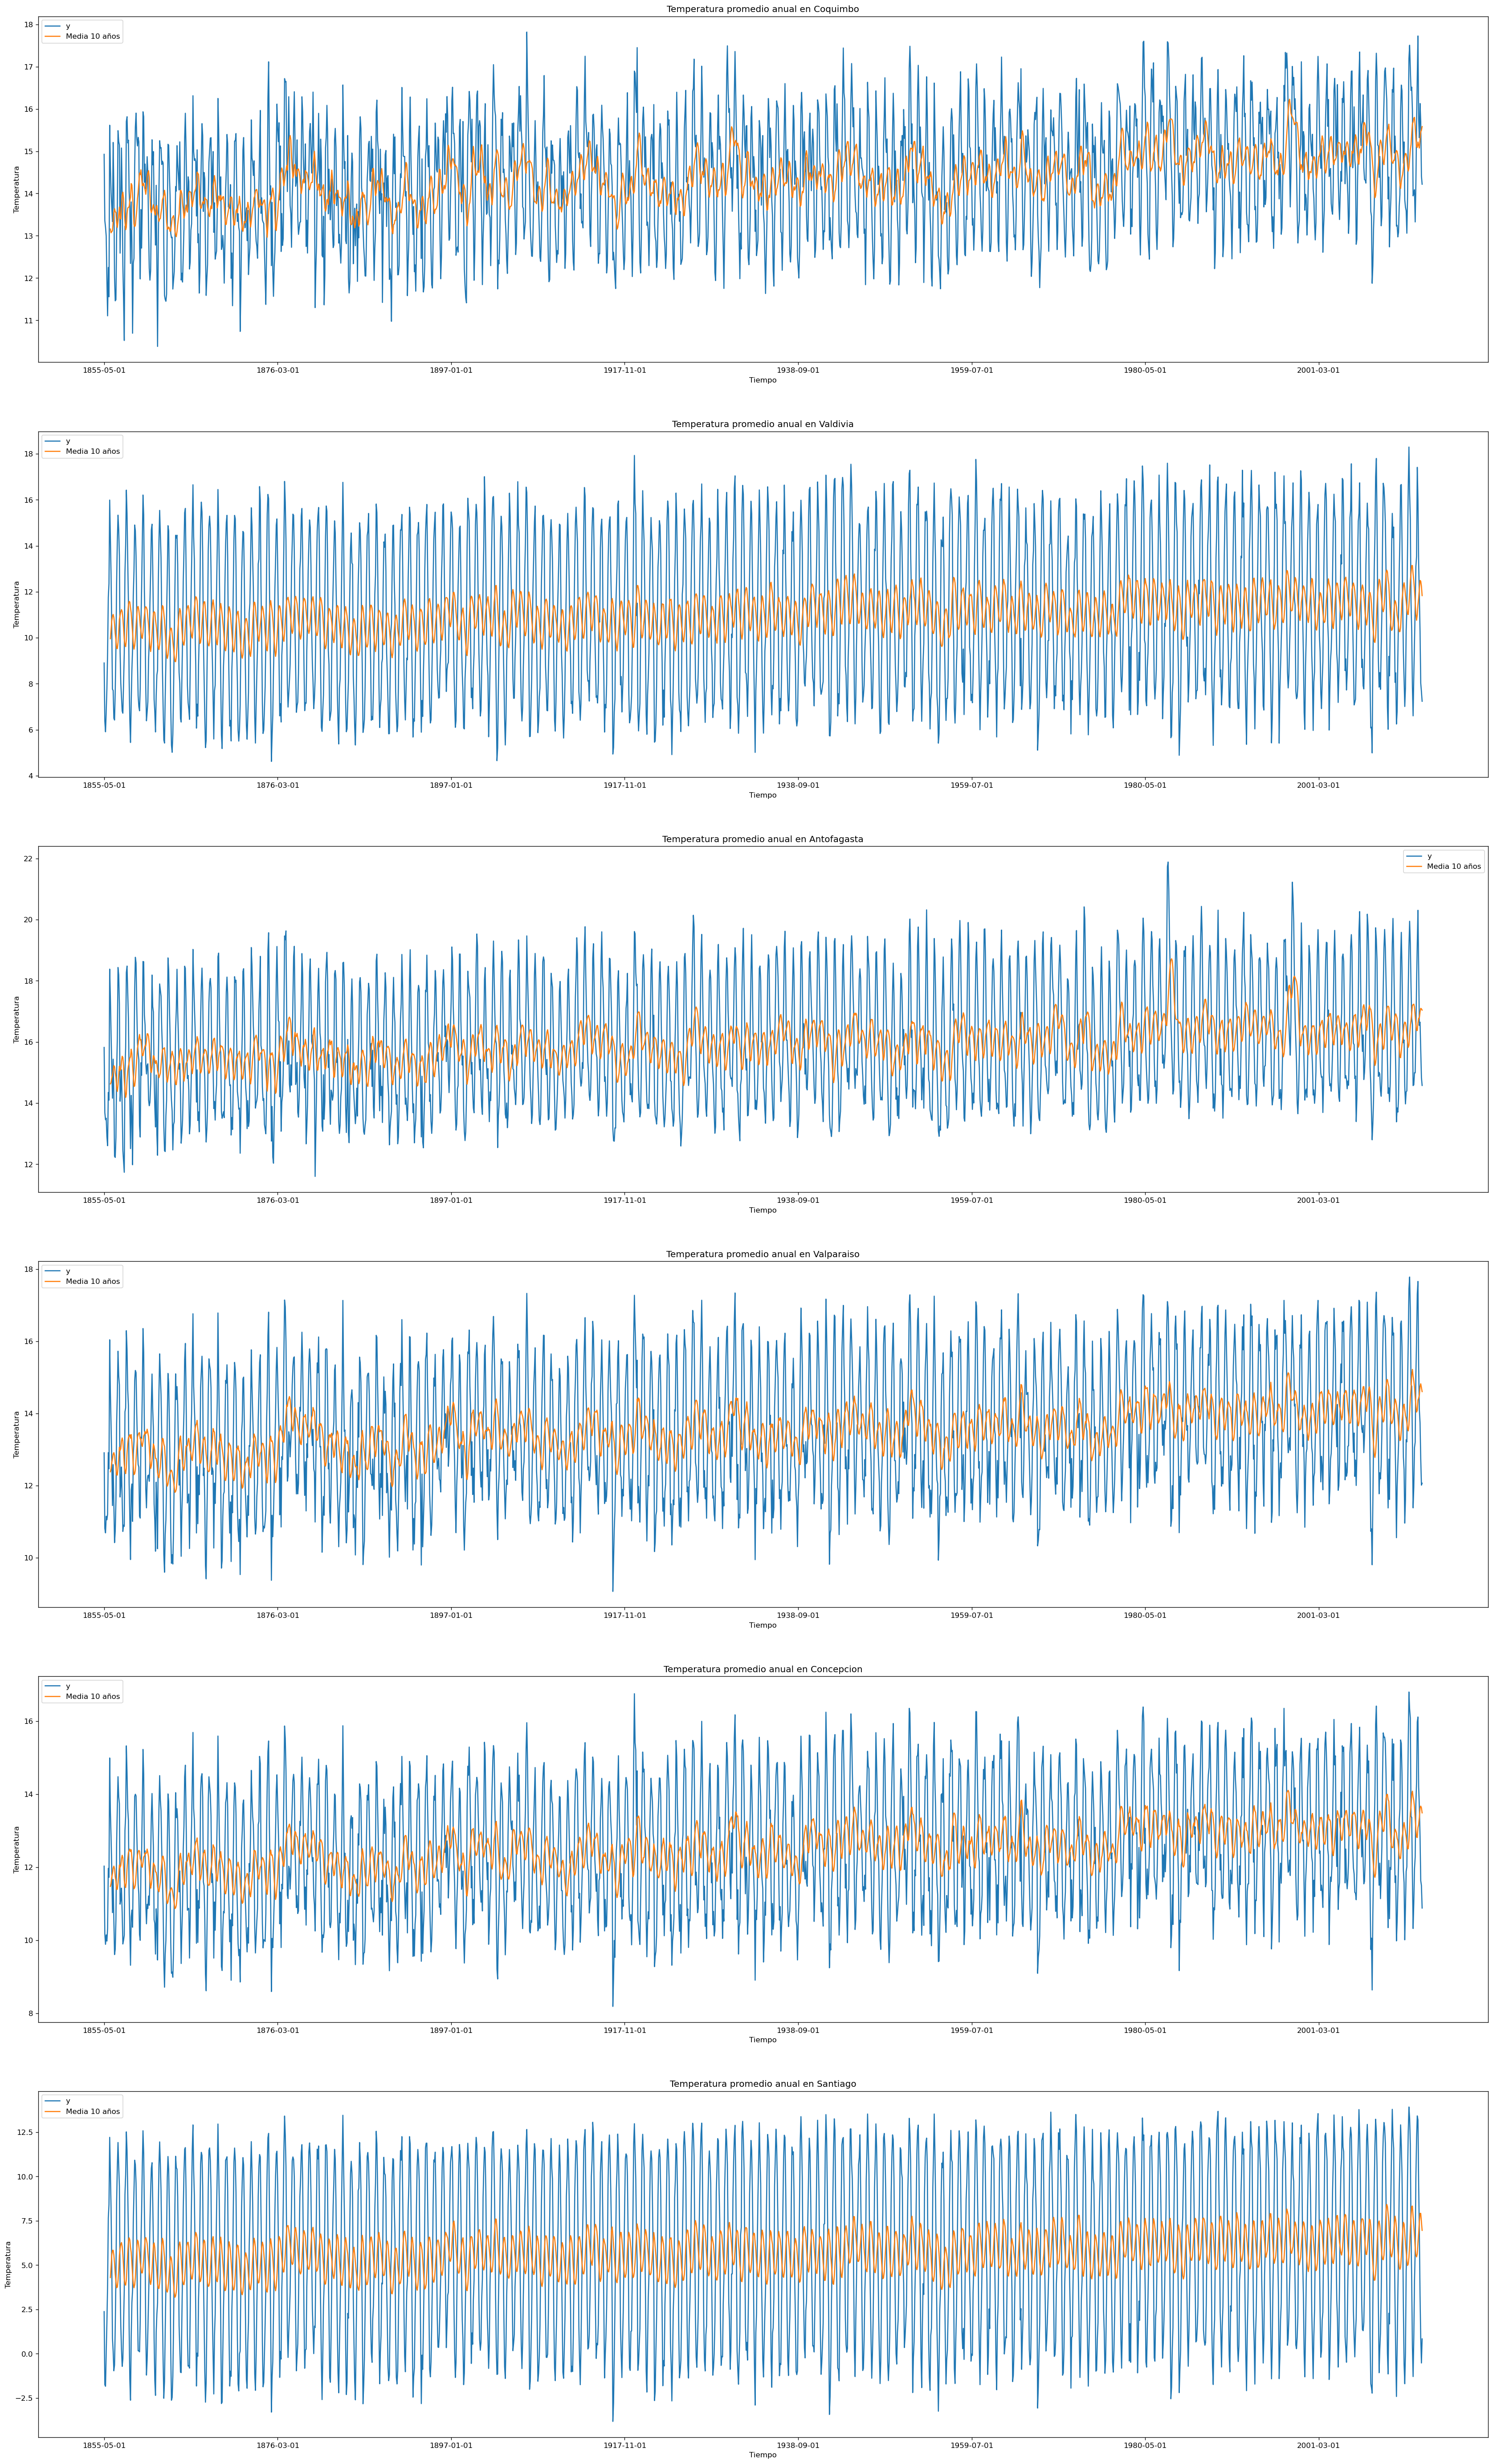

In [6]:
fig, axs = plt.subplots(6,1, figsize=(35,60), dpi=120)

for i in range(0, len(main_cities)):
    city_1 = dc_main_cities[main_cities[i]]
    
    year_avg = pd.pivot_table(city_1, values='y', index='ds', aggfunc='mean')
    year_avg['Media 10 años'] = year_avg['y'].rolling(10).mean()
    year_avg[['y', 'Media 10 años']].plot(ax=axs[i])
    
    axs[i].set_title('Temperatura promedio anual en %s' % main_cities[i])
    axs[i].set_ylabel('Temperatura')
    axs[i].set_xlabel('Tiempo')
    
plt.show()

Respecto a las curvas en general, es posible ver un leve incremento entre las temperaturas medias de todas la ciudades, siendo la única excepción la ciudad de Santiago. Por otro lado se puede ver que las ciudades de Concepción, Antofagasta y Valparaiso muestran una varianza mucho más significativas hacia temperaturas altas, mientras que las ciudades de Valdivia y Santiago muestran varianzas bastante altas en ambos sentidos, y por último, Coquimbo, que sus medias varían bastante en comparación con las otras ciudades.



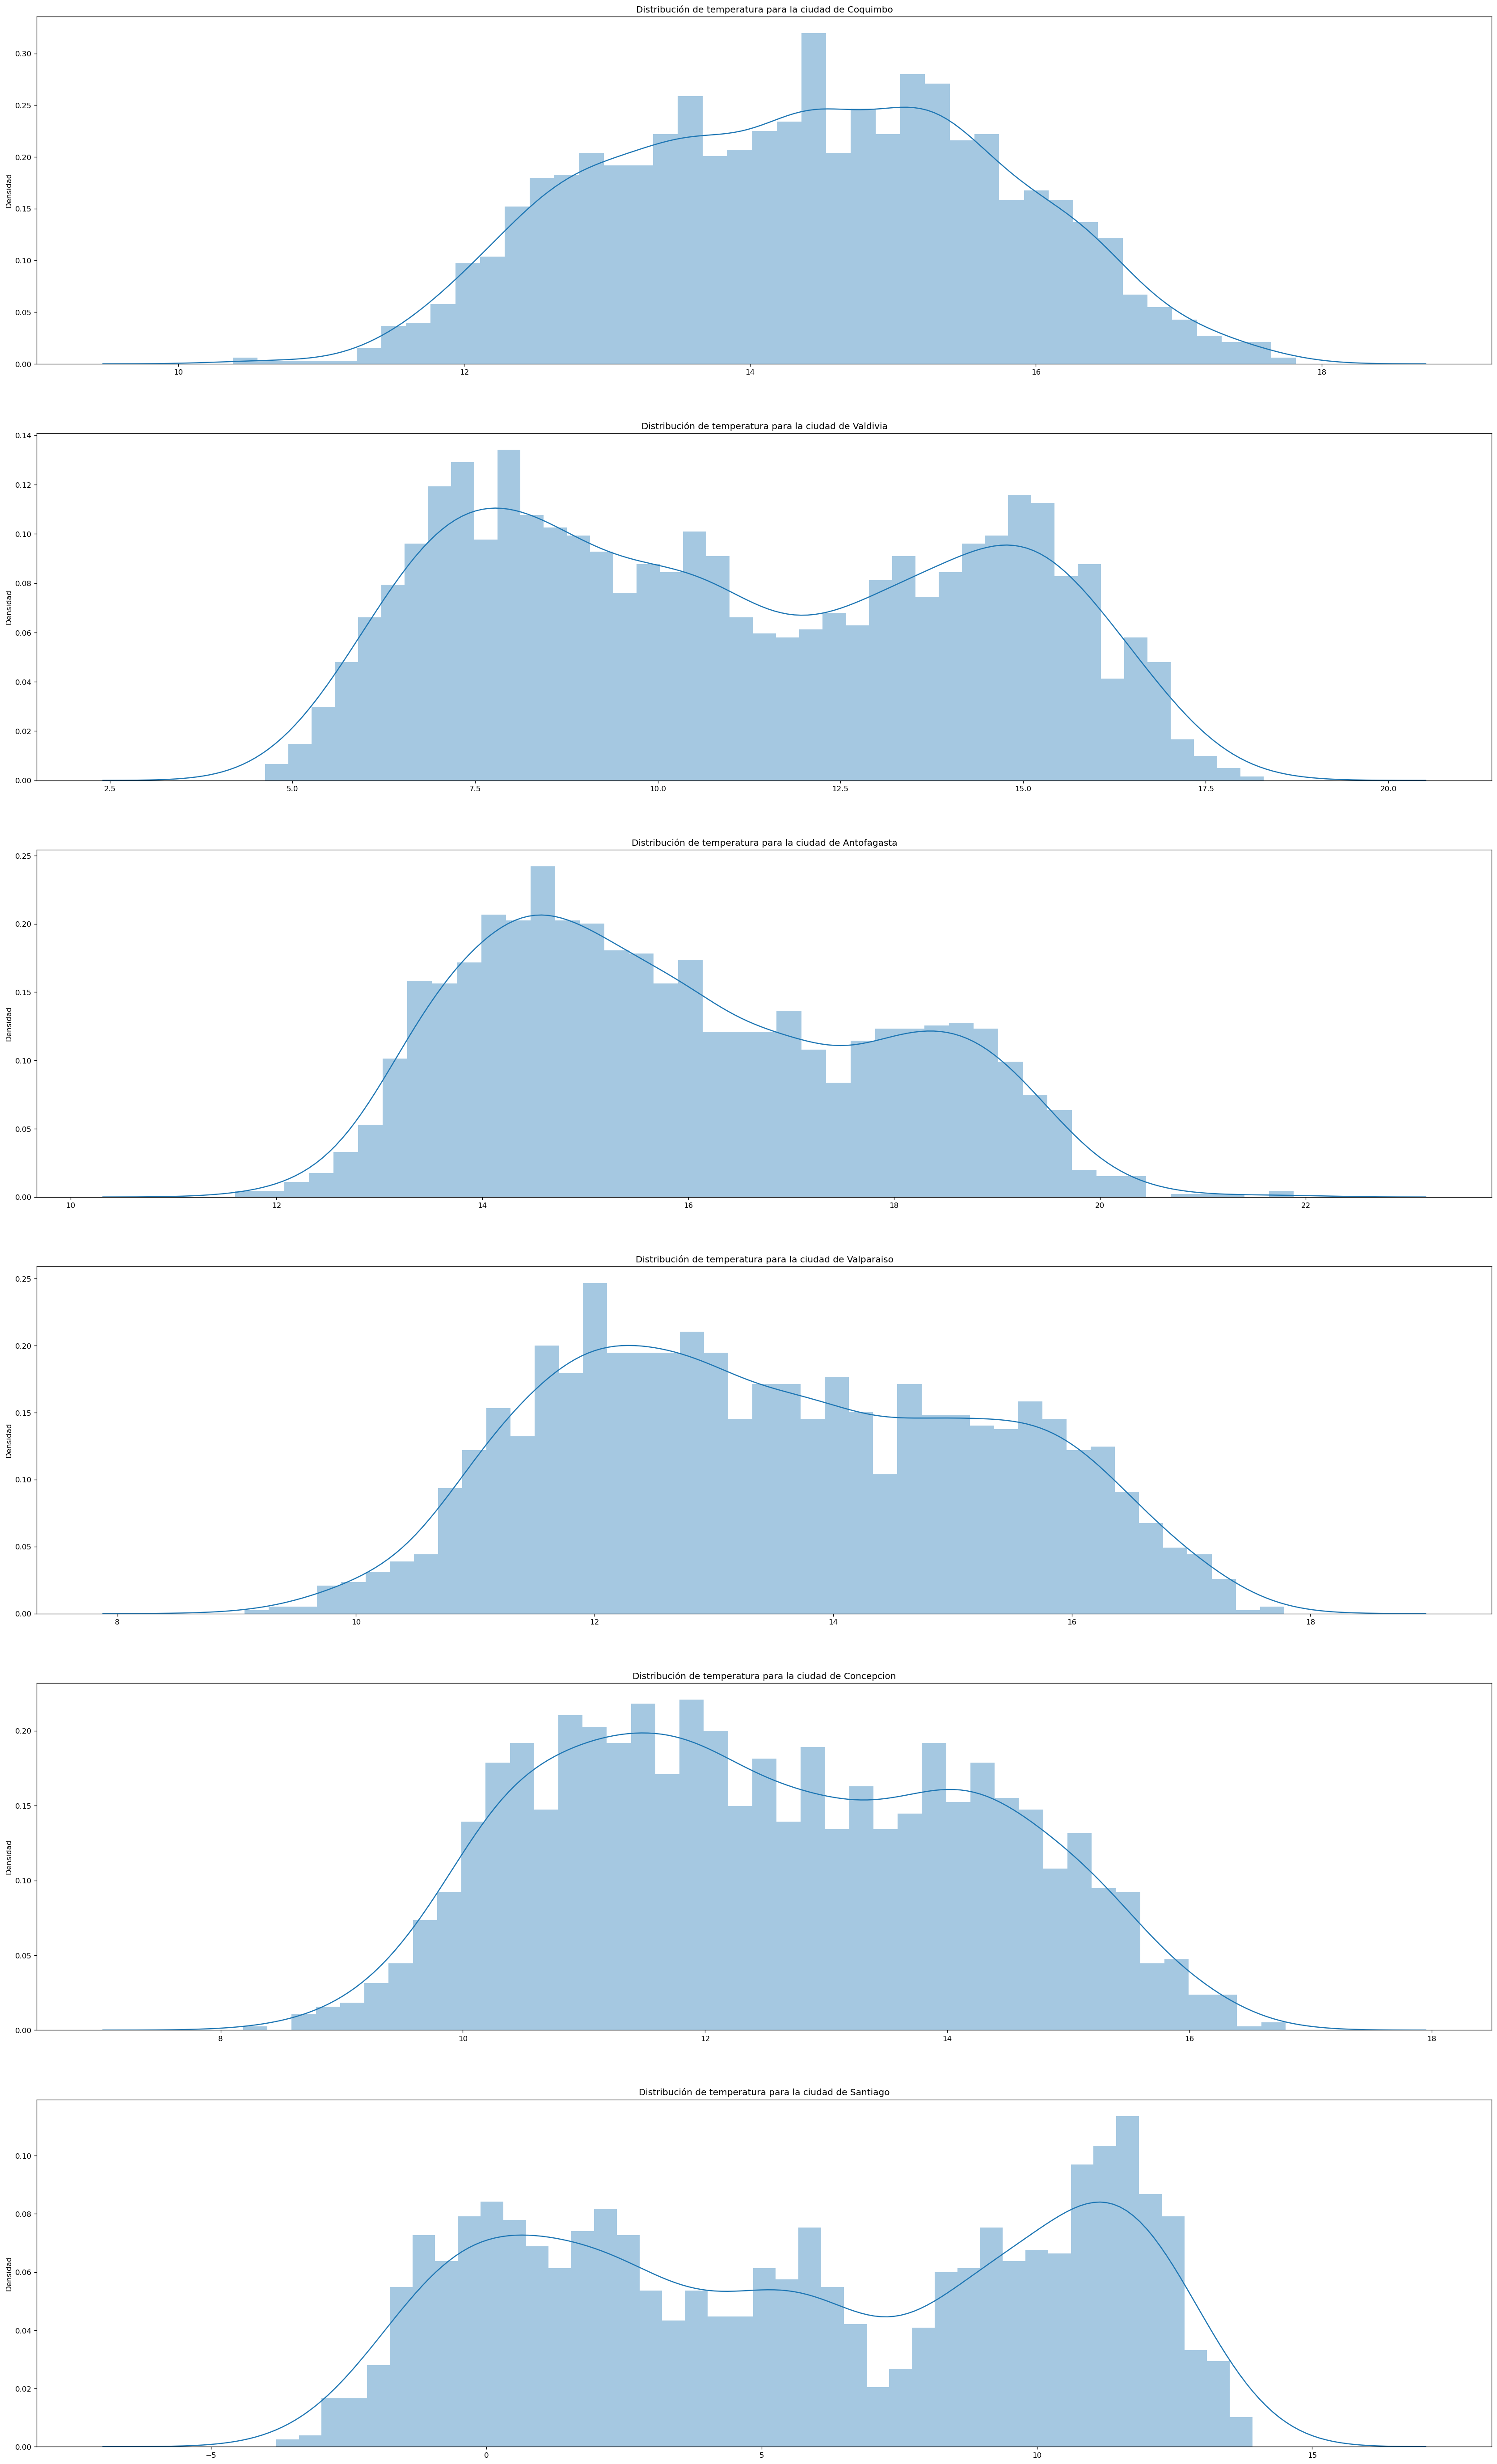

In [7]:
fig, axs = plt.subplots(6,1, figsize=(35,60), dpi=120)

for i in range(0, len(main_cities)):
    city_1 = dc_main_cities[main_cities[i]]['y'].values
    sns.distplot(city_1, bins=int(sqrt(len(city_1))), ax=axs[i])
    
    axs[i].set_title('Distribución de temperatura para la ciudad de %s' % main_cities[i])
    axs[i].set_ylabel('Densidad')

plt.show()

El gráfico de densidad de temperatura de la ciudad de Coquimbo muestra una distribución muy similar a lo que sería una distribución normal, lo que permite confirmar que el clima dentro de esa zona es bastante estable, donde solamente existe un sesgo hacia temperaturas mas cálidas, lo que es congruente con la ubicación geográfica de esta ciudad.

Por otro lado Valdivia muestra una dispersión mucho más grande de los datos, teniendo alta densidad de temperaturas altas como también de temperaturas bajas, lo cual se puede ver en las dos modas que muestra la curva. Esto nos hace pensar que Valdivia tiene un clima mucho más variable, lo que podría deberse a la presencia de microclimas dentro de la ciudad.

Antofagasta, muestra temperaturas bastante altas en comparacion con las anteriores, llegando a tener densidades significativas hasta 18°C.

Valparaiso, muestra una curva bastante plana, lo que muestra que las temperaturas no tienen temperaturas tan frecuentes como el caso de Valdivia, donde se podían identificar claramente las modas de las ciudades.

Concepción, de forma similar a lo que ocurre en Valparaíso, no se ve una moda clara en los datos, aunque acá se puede ver que la curva se encuentra más condensada, ya que la curva muestra densidades significativas hasta los 16°C, mientras que Valparaíso muestra temperaturas significativas entre los 17 y 18°C

Santiago, de forma similar a lo que ocurre en Valdivia, los datos muestran dos modas claras, lo que podria implicar microclimas o que las estaciones de invierno y verano son mucho más marcadas que el resto. 
Esta información es congruente con la información presentada anteriormente en los gráficos de varianza y medias por ciudades.

## Modelo - Prophet

### Introducción

Prophet es un procedimiento para hacer una serie de tiempo para prediccion basado en un modelo aditivo donde tendencias no lineales son ajustadas con datos estacionales anuales, semanales y diarios. Tiene un muy buen funcionamiento con series de tiempo que muestran efectos estacionales cargados y un buen conjunto de datos historico. Prophet es robusto frente a falta de informacion y cambios en las tendencias dentro de los datos, y tambien maneja efectivamente los outliers. 

### Prediccion

In [8]:
%%time
model_cities_prophet = dict()
for ct in main_cities:
    model_cities_prophet[ct] = Prophet()
    model_cities_prophet[ct].fit(dc_main_cities[ct].loc[:'1990'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

CPU times: user 3.55 s, sys: 118 ms, total: 3.67 s
Wall time: 4.06 s


In [9]:
%%time
main_cities_pred_val_prophet = dict()
for ct in main_cities:
    future_all = dc_main_cities[ct].loc['1990':]
    future_pred = model_cities_prophet[ct].predict(pd.DataFrame(future_all['ds']))['yhat']
    aux = pd.concat([future_all, pd.DataFrame(future_pred.values, index =future_all.index)], axis=1, ignore_index=True)
    aux.columns = ['ds', 'y_val', 'y_pred']
    main_cities_pred_val_prophet[ct] = aux

CPU times: user 18.2 s, sys: 149 ms, total: 18.4 s
Wall time: 18.4 s


### Analisis de resultados

In [10]:
for ct in main_cities:
    display(main_cities_pred_val_prophet[ct].head())

ds   y_val     y_pred
1990-01-01  1990-01-01  16.460  16.225186
1990-02-01  1990-02-01  16.219  16.683210
1990-03-01  1990-03-01  15.584  16.246469
1990-04-01  1990-04-01  15.045  15.376446
1990-05-01  1990-05-01  15.182  15.599215

ds   y_val     y_pred
1990-01-01  1990-01-01  16.129  16.323894
1990-02-01  1990-02-01  16.688  16.007579
1990-03-01  1990-03-01  13.820  14.221103
1990-04-01  1990-04-01  10.590  11.357121
1990-05-01  1990-05-01   8.955   9.464119

ds   y_val     y_pred
1990-01-01  1990-01-01  19.381  19.133606
1990-02-01  1990-02-01  18.938  19.588750
1990-03-01  1990-03-01  18.267  18.729473
1990-04-01  1990-04-01  17.169  17.191421
1990-05-01  1990-05-01  16.075  16.478434

ds   y_val     y_pred
1990-01-01  1990-01-01  16.868  16.528765
1990-02-01  1990-02-01  15.902  16.506228
1990-03-01  1990-03-01  14.987  15.635114
1990-04-01  1990-04-01  13.980  14.180946
1990-05-01  1990-05-01  12.927  13.566553

ds   y_val     y_pred
1990-01-01  1990-01-01  15.749  15.415144
1990-02-01  1990-02-01  15.161  15.302893
1990-03-01  1990-03-01  13.985  14.530643
1990-04-01  1990-04-01  12.958  13.178876
1990-05-01  1990-05-01  12.081  12.610375

ds   y_val     y_pred
1990-01-01  1990-01-01  13.311  12.713085
1990-02-01  1990-02-01  11.327  12.100171
1990-03-01  1990-03-01   9.159  10.153354
1990-04-01  1990-04-01   6.056   6.523340
1990-05-01  1990-05-01   2.629   3.075328

In [11]:
for ct in main_cities:
    MSE = mean_squared_error(main_cities_pred_val_prophet[ct]["y_val"],main_cities_pred_val_prophet[ct]["y_pred"])
    MAE = mean_absolute_error(main_cities_pred_val_prophet[ct]["y_val"],main_cities_pred_val_prophet[ct]["y_pred"])
    print("--------")
    print("El MSE para " + ct + " es: "+ str(MSE))
    print("El MAE para " + ct + " es: "+ str(MSE))
    print("--------")

--------
El MSE para Coquimbo es: 0.41176582862660466
El MAE para Coquimbo es: 0.41176582862660466
--------
--------
El MSE para Valdivia es: 0.6725455084095592
El MAE para Valdivia es: 0.6725455084095592
--------
--------
El MSE para Antofagasta es: 0.4596673019380358
El MAE para Antofagasta es: 0.4596673019380358
--------
--------
El MSE para Valparaiso es: 0.43305904267931805
El MAE para Valparaiso es: 0.43305904267931805
--------
--------
El MSE para Concepcion es: 0.4540115472515689
El MAE para Concepcion es: 0.4540115472515689
--------
--------
El MSE para Santiago es: 0.6890378054190327
El MAE para Santiago es: 0.6890378054190327
--------


Ambos errores medios, ya sea el error absoluto o el error cuadr[atico, para todas las ciudades son menores a un grado Celcius, lo cual nos puede decir que el modelo Prophet implementado logra predecir con mucha precisión las temperaturas.

## Modelo - ARIMA

### Introducción

ARIMA es un modelo estadístico que utiliza variaciones y regresiones de datos estadísticos con el fin de encontrar patrones para una predicción hacia el futuro. Se trata de un modelo dinámico de series temporales, es decir, las estimaciones futuras vienen explicadas por los datos del pasado y no por variables independientes. 

### Prediccion

In [12]:
%%time
model_cities_sarimax = dict()
for ct in main_cities:
    model_cities_sarimax[ct] = sm.tsa.statespace.SARIMAX(dc_main_cities[ct].loc[:'1990']['y'],\
                                                         order=(3,0,0), seasonal_order=(0,1,1,12), trend='c').fit(disp=False)

CPU times: user 1min 20s, sys: 1min 2s, total: 2min 23s
Wall time: 1min 14s


In [13]:
%%time
main_cities_pred_val_sarimax = dict()
for ct in main_cities:
    future_all = dc_main_cities[ct].loc['1990':]
    future_pred = model_cities_sarimax[ct].predict(start=future_all.index[0], end=future_all.index[-1])
    aux = pd.concat([future_all, pd.DataFrame(future_pred.values, index =future_all.index)], axis=1, ignore_index=True)
    aux.columns = ['ds', 'y_val', 'y_pred']
    main_cities_pred_val_sarimax[ct] = aux

CPU times: user 329 ms, sys: 0 ns, total: 329 ms
Wall time: 327 ms


### Analisis de resultados

In [14]:
for ct in main_cities:
    display(main_cities_pred_val_sarimax[ct].head())

ds   y_val     y_pred
1990-01-01  1990-01-01  16.460  16.379439
1990-02-01  1990-02-01  16.219  16.771751
1990-03-01  1990-03-01  15.584  16.067009
1990-04-01  1990-04-01  15.045  15.052322
1990-05-01  1990-05-01  15.182  15.242817

ds   y_val     y_pred
1990-01-01  1990-01-01  16.129  16.553498
1990-02-01  1990-02-01  16.688  16.065329
1990-03-01  1990-03-01  13.820  14.372721
1990-04-01  1990-04-01  10.590  11.343719
1990-05-01  1990-05-01   8.955   9.224571

ds   y_val     y_pred
1990-01-01  1990-01-01  19.381  19.219877
1990-02-01  1990-02-01  18.938  19.693303
1990-03-01  1990-03-01  18.267  18.425444
1990-04-01  1990-04-01  17.169  16.888947
1990-05-01  1990-05-01  16.075  16.245405

ds   y_val     y_pred
1990-01-01  1990-01-01  16.868  16.708573
1990-02-01  1990-02-01  15.902  16.657254
1990-03-01  1990-03-01  14.987  15.478169
1990-04-01  1990-04-01  13.980  13.903638
1990-05-01  1990-05-01  12.927  13.280464

ds   y_val     y_pred
1990-01-01  1990-01-01  15.749  15.681330
1990-02-01  1990-02-01  15.161  15.494945
1990-03-01  1990-03-01  13.985  14.535435
1990-04-01  1990-04-01  12.958  13.013020
1990-05-01  1990-05-01  12.081  12.376296

ds   y_val     y_pred
1990-01-01  1990-01-01  13.311  12.962431
1990-02-01  1990-02-01  11.327  12.338397
1990-03-01  1990-03-01   9.159  10.054082
1990-04-01  1990-04-01   6.056   6.223291
1990-05-01  1990-05-01   2.629   2.670014

In [15]:
for ct in main_cities:
    MSE = mean_squared_error(main_cities_pred_val_sarimax[ct]["y_val"],main_cities_pred_val_sarimax[ct]["y_pred"])
    MAE = mean_absolute_error(main_cities_pred_val_sarimax[ct]["y_val"],main_cities_pred_val_sarimax[ct]["y_pred"])
    print("--------")
    print("El MSE para " + ct + " es: "+ str(MSE))
    print("El MAE para " + ct + " es: "+ str(MSE))
    print("--------")

--------
El MSE para Coquimbo es: 0.3839227116907454
El MAE para Coquimbo es: 0.3839227116907454
--------
--------
El MSE para Valdivia es: 0.6703969399920782
El MAE para Valdivia es: 0.6703969399920782
--------
--------
El MSE para Antofagasta es: 0.3817422338972121
El MAE para Antofagasta es: 0.3817422338972121
--------
--------
El MSE para Valparaiso es: 0.42680698481178797
El MAE para Valparaiso es: 0.42680698481178797
--------
--------
El MSE para Concepcion es: 0.4455275452661518
El MAE para Concepcion es: 0.4455275452661518
--------
--------
El MSE para Santiago es: 0.7050533541765094
El MAE para Santiago es: 0.7050533541765094
--------


Del mismo modo que para el modelo Prophet, los errores absolutos y cuadráticos no alcanzan a llegar a grado celcius, siendo los resultados bastante similares, con la excepción de las ciudades de Santiago y Coquimbo, donde los valores entregados difieren en un grado mayor que para los otros datos, pero sin llegar a implicar una diferencia significativa dentro de los modelos implementados.

## Análisis General

Basado en los resultados obtenidos, específicamente en los estadísticos del MAE y MSE, no se puede notar una superioridad clara entre los modelos estudiados, pero si se puede ver cierto patrones basados en la distribuciones de los datos. Para datos que poseen menor varianza entre ellos, como lo son los de las ciudades de Valdivia, Valparaíso, Concepción y Antofagasta, el modelo Prophet entrega errores menores que los que entrega el modelo ARIMA. Por otro lado, el modelo ARIMA muestra mejoras sobre el modelo Prophet en los casos en que las varianzas de los datos no son tan estables como en los casos anteriores, entregando modelos que se ajustan mucho mejor a este tipo de datos. Con esto se puede confirmar que es necesario hacer un análisis exploratorio de los datos antes de realizar los modelos de regresión, debido a que, al conocer ciertos atributos de los datos, podemos llegar a la elección de los modelos de mejor manera y así mismo, obtener mejores resultados de la predicción.